In [1]:
import os
import shutil
import random
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

'''
Set config for data preprocessing
train_dir_before_split -> is in initial training data before spliting into training and validation
train_dir_before_split -> Place the initial training directory here
train_dir -> "training directory after spliting"
validation_dir -> "validation directory after spliting"
'''

@dataclass
class PreprocessingConfig:
    train_dir_before_split: str
    train_dir: str  # New training directory after splitting ( Don't have to manually create just place the file path)
    validation_dir: str  # New validation directory after splitting ( Don't have to manually create just place the file path)
    split_ratio: float
    target_size: tuple # set target size to be compatible with input base model
    batch_size: int

class DataPreprocessor:
    def __init__(self, config: PreprocessingConfig):
        self.config = config

    def split_data(self):
        if os.path.exists(self.config.validation_dir) and os.path.exists(self.config.train_dir):
            raise Exception("Data has already been split. The directories already exist.")

        if not os.path.exists(self.config.validation_dir):
            os.makedirs(self.config.validation_dir)
        if not os.path.exists(self.config.train_dir):
            os.makedirs(self.config.train_dir)
        
        for class_name in os.listdir(self.config.train_dir_before_split):
            class_dir = os.path.join(self.config.train_dir_before_split, class_name)
            if os.path.isdir(class_dir):
                images = os.listdir(class_dir)
                train_images, val_images = train_test_split(images, test_size=self.config.split_ratio, random_state=42)
                class_val_dir = os.path.join(self.config.validation_dir, class_name)
                class_train_dir = os.path.join(self.config.train_dir, class_name)
                if not os.path.exists(class_val_dir):
                    os.makedirs(class_val_dir)
                for val_image in val_images:
                    shutil.copy(os.path.join(class_dir, val_image), os.path.join(class_val_dir, val_image))

                if not os.path.exists(class_train_dir):
                    os.makedirs(class_train_dir)
                for train_image in train_images:
                    shutil.copy(os.path.join(class_dir, train_image), os.path.join(class_train_dir, train_image))


    def get_data_generators(self):
        '''
        Rescaling the pixel array in to range 0-1 by divided by 255 since the data is in 8 bit (0-255)
        Using desire augmentation type (Eg, rotation, zoom_range , etc)

        Validation only apply normalization with out augmentation since the validation set suppose to be monitoring the training process
        and keep in form of real world senario without any synthetic data or generation data
        '''
        train_datagen = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=10,
            zoom_range=0.1,
            horizontal_flip=True
        )

        val_datagen = ImageDataGenerator(rescale=1.0/255)

        train_generator = train_datagen.flow_from_directory(
            self.config.train_dir,
            target_size=self.config.target_size,
            batch_size=self.config.batch_size,
            class_mode='categorical'
        )

        validation_generator = val_datagen.flow_from_directory(
            self.config.validation_dir,
            target_size=self.config.target_size,
            batch_size=self.config.batch_size,
            class_mode='categorical'
        )

        return train_generator, validation_generator



2024-05-17 16:18:43.860963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 16:18:43.861084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 16:18:43.918701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 16:18:44.043157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 16:18:46.078606: W tensorflow/compiler/tf2

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import Xception , InceptionV3 , InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten ,Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    input_shape: tuple
    num_classes: int
    epochs: int
    learning_rate: float
    model_save_path: str
    evaluation_save_path: str
    patience: int

class ModelTrainer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.model = None
        self.model_name = ""

    def prepare_Xception(self):
        self.model_name = "Xception"
        base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=self.config.input_shape)
        base_model.trainable = False

        for layer in base_model.layers[-10:]:
            layer.trainable = True

        # Add custom layers on top of the base model
        x = base_model.output
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='custom_conv')(x)
        x = Flatten()(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(rate=0.25)(x)
        outputs = Dense(4, activation='softmax')(x)
        # Create the complete model
        self.model = Model(inputs=base_model.input, outputs=outputs)

    def prepare_InceptionV3(self):
        self.model_name = "InceptionV3"
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=self.config.input_shape)
        base_model.trainable = False


        # Add custom layers on top of the base model
        x = base_model.output
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='custom_conv')(x)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(rate=0.5)(x)
        x = Dense(1024, activation='relu')(x)
        outputs = Dense(4, activation='softmax')(x)
        # Create the complete model
        self.model = Model(inputs=base_model.input, outputs=outputs)

    def prepare_InceptionResNetV2(self):
        self.model_name = "InceptionResNetV2"
        base_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=self.config.input_shape)
        base_model.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='custom_conv')(x)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(rate=0.55)(x)
        x = Dense(60,activation ='elu' , kernel_initializer='GlorotNormal')
        x = Dropout(rate=0.3)(x)
        outputs = Dense(4, activation='softmax')(x)
        # Create the complete model
        self.model = Model(inputs=base_model.input, outputs=outputs)

    

    

    def print_model_summary(self):
        if self.model is None:
            raise ValueError("Model is not prepared. Call a prepare_* method first.")
        self.model.summary()

    def compile_model(self, learning_rate=None):
        if self.model is None:
            raise ValueError("Model is not prepared. Call a prepare_* method first.")
        
        if learning_rate is None:
            learning_rate = self.config.learning_rate
        
        self.model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy']
        )

    def train_model(self, train_generator, validation_generator):
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=self.config.patience, restore_best_weights=True)
        
        if not os.path.exists(self.config.model_save_path):
            os.makedirs(self.config.model_save_path)

        model_checkpoint = ModelCheckpoint(
            filepath=os.path.join(self.config.model_save_path, f'best_model_{self.model_name}.h5'),
            monitor='val_loss', save_best_only=True)
        
        lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=9, min_delta = 0.0001)

        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            epochs=self.config.epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[early_stopping, model_checkpoint , lr_scheduler]
        )

        return history

    def fine_tune_model(self, train_generator, validation_generator, fine_tune_learning_rate, load_model_path=None):

        """
        Method for fine tuning model If you prefer to fine tune the save model again with lower learning rate or unfreeze layer
        """
        if load_model_path:
            self.model = load_model(load_model_path)
            self.model_name = os.path.basename(load_model_path).split('.')[0]
        elif self.model is None:
            raise ValueError("No model is loaded or prepared. Please prepare a model or provide a path to a saved model.")

        # Unfreeze the last 10 layers of the base model
        for layer in self.model.layers[-5:]:
            layer.trainable = True

        self.compile_model(learning_rate=fine_tune_learning_rate)

        early_stopping = EarlyStopping(
            monitor='val_loss', patience=self.config.patience, restore_best_weights=True)
        
        model_checkpoint = ModelCheckpoint(
            filepath=os.path.join(self.config.model_save_path, f'best_model_fine_tuned_{self.model_name}.h5'),
            monitor='val_loss', save_best_only=True)

        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            epochs=self.config.epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[early_stopping, model_checkpoint]
        )

        return history

    def plot_history(self, history):
        if not os.path.exists(self.config.evaluation_save_path):
            os.makedirs(self.config.evaluation_save_path)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.savefig(os.path.join(self.config.evaluation_save_path, f'accuracy_plot_{self.model_name}.png'))

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.savefig(os.path.join(self.config.evaluation_save_path, f'loss_plot_{self.model_name}.png'))

        plt.show()



# Preprocess for using Xceptionnet Target_size = (299,299) for effientnet (if we are using the same input size as base model)

In [9]:
'''
Set config for data preprocessing
train_dir_before_split -> is in initial training data before spliting into training and validation
train_dir_before_split -> Place the initial training directory here
train_dir -> "training directory after spliting"
validation_dir -> "validation directory after spliting"
'''
preprocessing_config = PreprocessingConfig(
    train_dir_before_split='Data/Initial_training',
    train_dir='Data/Training',
    validation_dir='Data/Validation',
    split_ratio=0.2,
    target_size=(299,299),
    batch_size=16
)

preprocessor = DataPreprocessor(preprocessing_config)

# Split data if not already done
try:
    preprocessor.split_data()
except Exception as e:
    print(e)


train_generator, validation_generator = preprocessor.get_data_generators()

# Print shapes to check compatibility with the model
print(f"Train batch shape: {train_generator.image_shape}")
print(f"Validation batch shape: {validation_generator.image_shape}")

Data has already been split. The directories already exist.
Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Train batch shape: (299, 299, 3)
Validation batch shape: (299, 299, 3)


# Prepare model using effiecientnet set any config you want to use 

In [10]:
'''
Prepare the config for training 

'''
num_classes = len(train_generator.class_indices)
training_config = TrainingConfig(
    input_shape=(299, 299, 3),
    num_classes=num_classes,
    epochs=150,
    learning_rate=0.001,
    model_save_path='Model',
    evaluation_save_path='Evaluation',
    patience=7
)

trainer = ModelTrainer(training_config)
trainer.prepare_Xception()  
trainer.print_model_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

#Train the model

Epoch 1/150
285/285 [==============================] - ETA: 0s - loss: 0.8130 - accuracy: 0.7830

/home/acie503248/anaconda3/envs/classification/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 109s 363ms/step - loss: 0.8130 - accuracy: 0.7830 - val_loss: 0.3842 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 2/150
285/285 [==============================] - 106s 372ms/step - loss: 0.3082 - accuracy: 0.8959 - val_loss: 0.2418 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 3/150
285/285 [==============================] - 106s 373ms/step - loss: 0.2331 - accuracy: 0.9246 - val_loss: 0.2274 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 4/150
285/285 [==============================] - 106s 371ms/step - loss: 0.1912 - accuracy: 0.9337 - val_loss: 0.2749 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 5/150
285/285 [==============================] - 107s 376ms/step - loss: 0.1934 - accuracy: 0.9370 - val_loss: 0.1501 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 6/150
285/285 [==============================] - 108s 378ms/step - loss: 0.1477 - accuracy: 0.9497 - val_loss: 0.1382 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 7/150
285/285 [==============================]

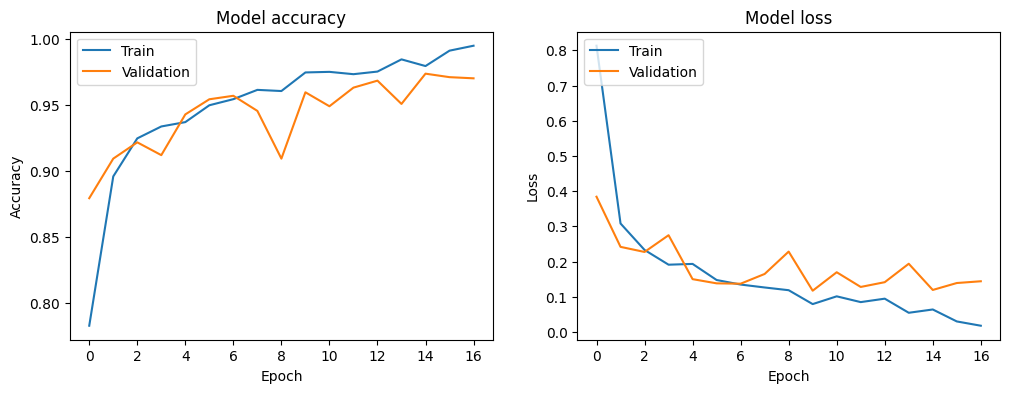

In [11]:

trainer.compile_model()
history = trainer.train_model(train_generator, validation_generator)
trainer.plot_history(history)

# Train for InceptionV3

In [7]:
preprocessing_config = PreprocessingConfig(
    train_dir_before_split='Data/Initial_training',
    train_dir='Data/Training',
    validation_dir='Data/Validation',
    split_ratio=0.2,
    target_size=(299,299),
    batch_size=16
)

preprocessor = DataPreprocessor(preprocessing_config)

train_generator, validation_generator = preprocessor.get_data_generators()

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.


In [8]:


# Print shapes to check compatibility with the model
print(f"Train batch shape: {train_generator.image_shape}")
print(f"Validation batch shape: {validation_generator.image_shape}")
num_classes = len(train_generator.class_indices)
training_config = TrainingConfig(
    input_shape=(299, 299, 3),
    num_classes=num_classes,
    epochs=150,
    learning_rate=0.0001,
    model_save_path='Model',
    evaluation_save_path='Evaluation',
    patience=7
)

trainer = ModelTrainer(training_config)
trainer.prepare_InceptionV3()  
trainer.print_model_summary()

Train batch shape: (299, 299, 3)
Validation batch shape: (299, 299, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activat

Epoch 1/150


2024-05-17 16:20:59.039216: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-17 16:20:59.345192: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 16:21:01.548739: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 16:21:01.951414: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 16:21:08.051229: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

253/285 [=========================>....] - ETA: 10s - loss: 0.6383 - accuracy: 0.7502

2024-05-17 16:22:31.195470: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 16:22:31.404864: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 16:22:36.474836: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 16:22:36.605718: W external/local_tsl/tsl/framework/bfc_

285/285 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7572

/home/acie503248/anaconda3/envs/classification/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 125s 382ms/step - loss: 0.6169 - accuracy: 0.7572 - val_loss: 0.3539 - val_accuracy: 0.8715 - lr: 1.0000e-04
Epoch 2/150
285/285 [==============================] - 100s 352ms/step - loss: 0.3943 - accuracy: 0.8561 - val_loss: 0.3004 - val_accuracy: 0.8917 - lr: 1.0000e-04
Epoch 3/150
285/285 [==============================] - 109s 382ms/step - loss: 0.3412 - accuracy: 0.8770 - val_loss: 0.2713 - val_accuracy: 0.9023 - lr: 1.0000e-04
Epoch 4/150
285/285 [==============================] - 110s 386ms/step - loss: 0.3048 - accuracy: 0.8866 - val_loss: 0.2333 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 5/150
285/285 [==============================] - 112s 393ms/step - loss: 0.2782 - accuracy: 0.8963 - val_loss: 0.2148 - val_accuracy: 0.9243 - lr: 1.0000e-04
Epoch 6/150
285/285 [==============================] - 103s 362ms/step - loss: 0.2564 - accuracy: 0.9093 - val_loss: 0.2707 - val_accuracy: 0.8961 - lr: 1.0000e-04
Epoch 7/150
285/285 [=======

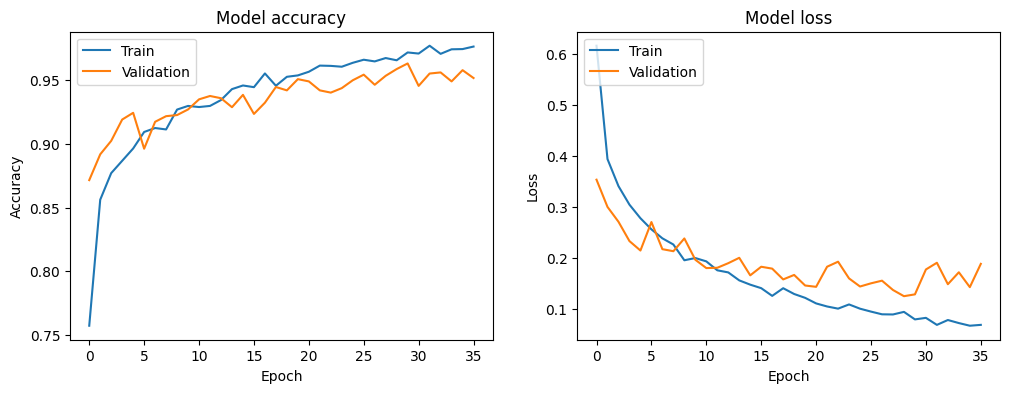

In [9]:

trainer.compile_model()
history = trainer.train_model(train_generator, validation_generator)
trainer.plot_history(history)

In [ ]:
# Fine tuning the model



# history = trainer.fine_tune_model(train_generator,validation_generator,fine_tune_learning_rate = 0.0001)



# num_classes = len(train_generator.class_indices)
# training_config = TrainingConfig(
#     input_shape=(299, 299, 3),
#     num_classes=num_classes,
#     epochs=150,
#     learning_rate=0.001,
#     model_save_path='Model',
#     evaluation_save_path='Evaluation',
#     patience=7
# )

# fine_tune_training = ModelTrainer(training_config)

# history = fine_tune_training.fine_tune_model(train_generator,validation_generator,fine_tune_learning_rate = 0.000001 , load_model_path='../../')
